## ライブラリー「Darts」を使った時系列分析

In [1]:
# ライブラリーのインポート
import darts
from darts import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift
from darts.models import ExponentialSmoothing
from darts.models import Theta, FourTheta
from darts.models import ARIMA
from darts.models import FFT
#from darts.models import RNNModel
#from darts.models import TCNModel
#from darts.models import NBEATSModel
#from darts.models import TransformerModel
#from darts.models import Prophet
#from darts.models import AutoARIMA

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

[2021-01-16 12:28:33,634] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-01-16 12:28:33,636] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[fbprophet] or u8darts[all].
[2021-01-16 12:28:33,641] WARNING | darts.models | Support Torch based models not available. To enable it, install u8darts[torch] or u8darts[all].


In [2]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('data/AirPassengers.csv')
# データの中身を確認
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# DartsのTimeSeriesに変換
series = TimeSeries.from_dataframe(df, time_col='Month', value_cols='#Passengers')

Text(0.5, 0, 'Year')

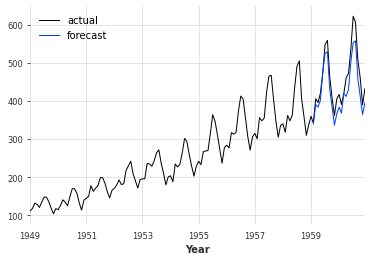

In [4]:
# 1959-01以前と以後に分割
train, val = series.split_after(pd.Timestamp('1959-01'))

# ExponentialSmoothing
# モデル生成
model_es = ExponentialSmoothing()

# 学習
model_es.fit(train) 

# 予測 (predictには予測数を入れることに注意)
historical_fcast_es = model_es.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
historical_fcast_es.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

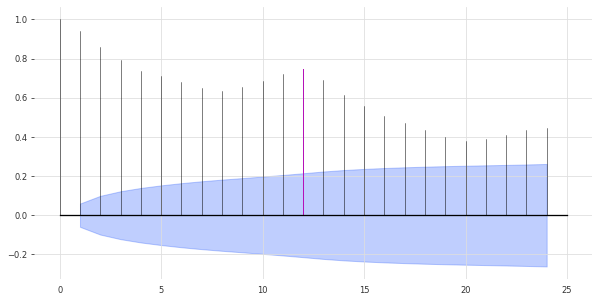

In [5]:
plot_acf(train, m = 12, alpha = .05)

Text(0.5, 0, 'Year')

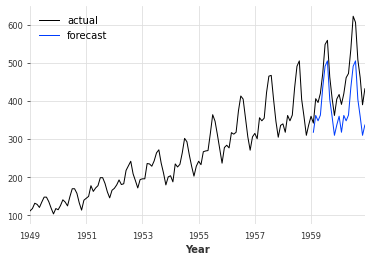

In [6]:
# NaiveSeasonal
# モデル生成
seasonal_model = NaiveSeasonal(K=12)
# 学習
seasonal_model.fit(train)
# 予測
seasonal_forecast = seasonal_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
seasonal_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

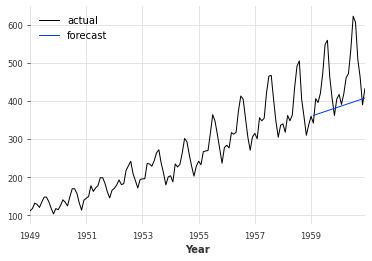

In [7]:
# NaiveDrift
# モデル生成
drift_model = NaiveDrift()
# 学習
drift_model.fit(train) 
# 予測
drift_forecast = drift_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
drift_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

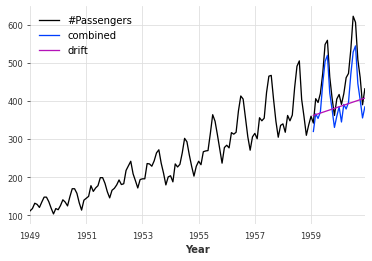

In [8]:
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend()
plt.xlabel('Year')

In [9]:
darts.__version__

'0.5.0'

In [10]:
# Search for the best theta parameter, by trying 50 different values
# Theta
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

Text(0.5, 0, 'Year')

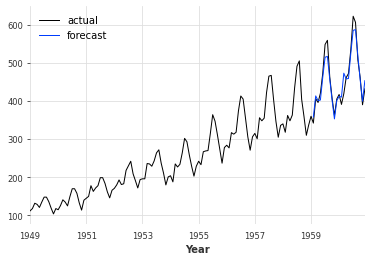

In [11]:
# Theta
# モデル生成
best_theta_model = Theta(best_theta)
# 学習
best_theta_model.fit(train) 
# 予測
pred_best_theta = best_theta_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
pred_best_theta.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')